In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

# 1. Первичный и визуальный анализ данных

In [2]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)

X.shape, y.shape

((20640, 8), (20640,))

In [3]:
df = pd.concat([X, y], axis=1)

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

В датасете 9 вещественных признаков и 20640 наблюдений. Пропусков нет. Целевой признак – `MedHouseVal`

In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


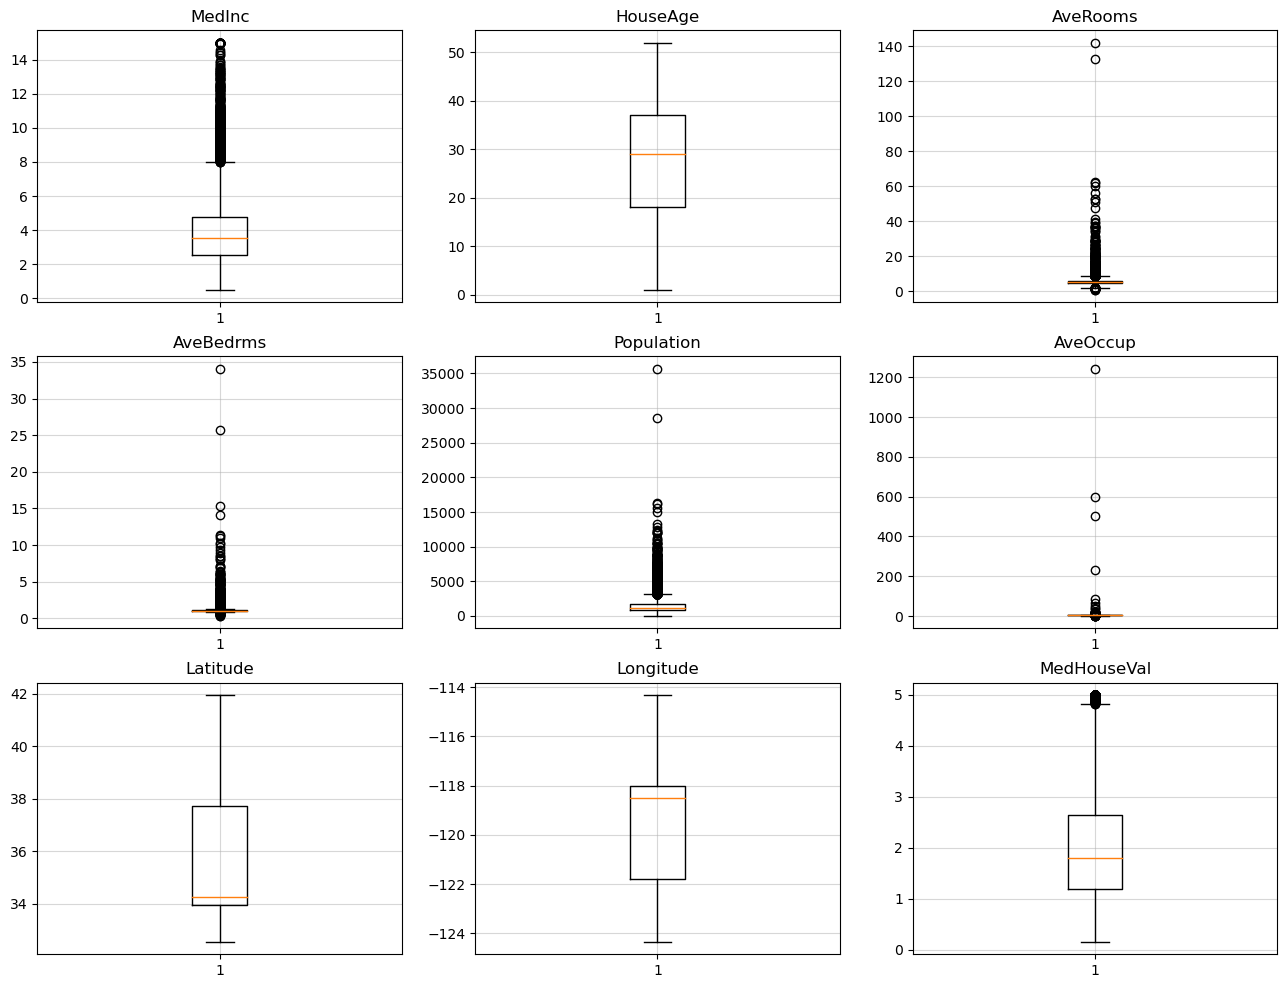

In [8]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(df.columns):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(df[col])
    plt.title(col)
    plt.grid(alpha=.5)

Признаки `MedInc`, `AveRooms`, `AveBedrms`, `Population` и `AveOccup`, а также целевой признак `MedHouseVal` имеют выбросы.

Корреляционная матрица:

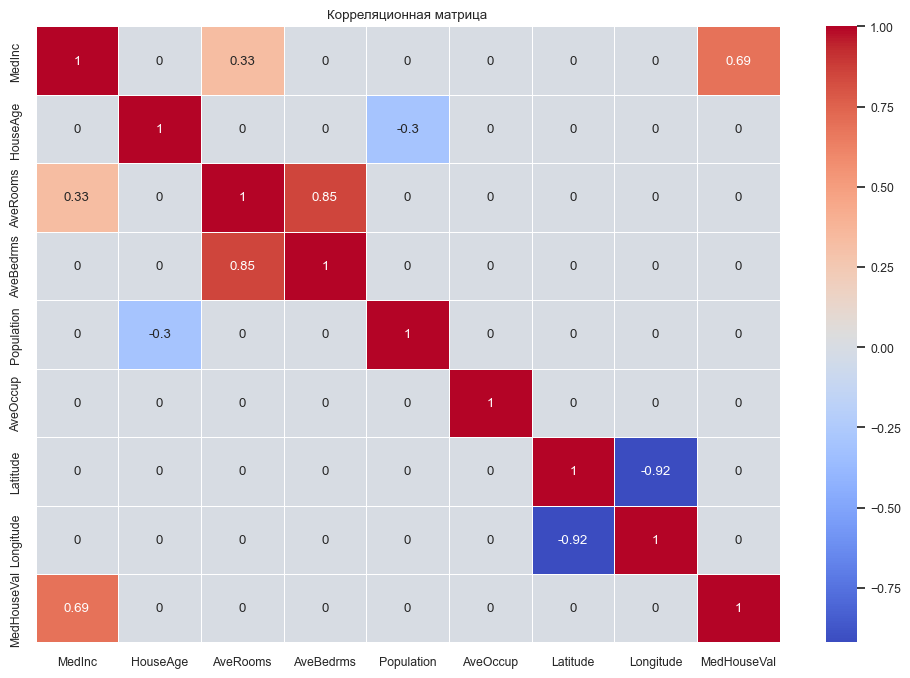

In [9]:
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

plt.figure(figsize=(12, 8))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Корреляционная матрица')
plt.show();

Корреляционная матрица показала, что целевой признак `MedHouseVal` сильно коррелирует с признаком `MedInc`

# 2. Базовое решение

In [201]:
num_epochs = 10
verbose = 0

In [246]:
stata = pd.DataFrame(columns=['Название модели',
                              'Кол-во скрытых слоев',
                              'Кол-во нейронов скрытых слоев',
                              'Ф-я активации',
                              'Оптимизатор',
                              'Metric Test',
                              'R2 test-pred']
                              )
stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,Metric Test,R2 test-pred


In [247]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(df.drop('MedHouseVal', axis=1)
                                                    , df['MedHouseVal']
                                                    , test_size=.2
                                                    , random_state=42)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [248]:
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.models import Sequential

In [249]:
tf.random.set_seed(42)

base_model = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(100, activation='relu'),
    Dense(1),
]
)

base_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 100)               900       
                                                                 
 dense_134 (Dense)           (None, 1)                 101       
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [250]:
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD

base_model.compile(optimizer=SGD(),
                   loss=mean_absolute_error,
                   metrics=['mae'])

In [251]:
%%time

history = base_model.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 11.2 s, sys: 1.25 s, total: 12.4 s
Wall time: 14.4 s


In [252]:
loss_test, metric_test = base_model.evaluate(X_test, y_test, verbose=0)
print(f'loss_test={loss_test:.5f}, metric_test={metric_test:.5f}')

loss_test=0.52283, metric_test=0.52283


In [253]:
from sklearn.metrics import r2_score

preds = base_model.predict(X_test, verbose=verbose)
r2_test = r2_score(y_test, preds)
print(f'r2_test = {r2_test:.5f}')

r2_test = 0.56531


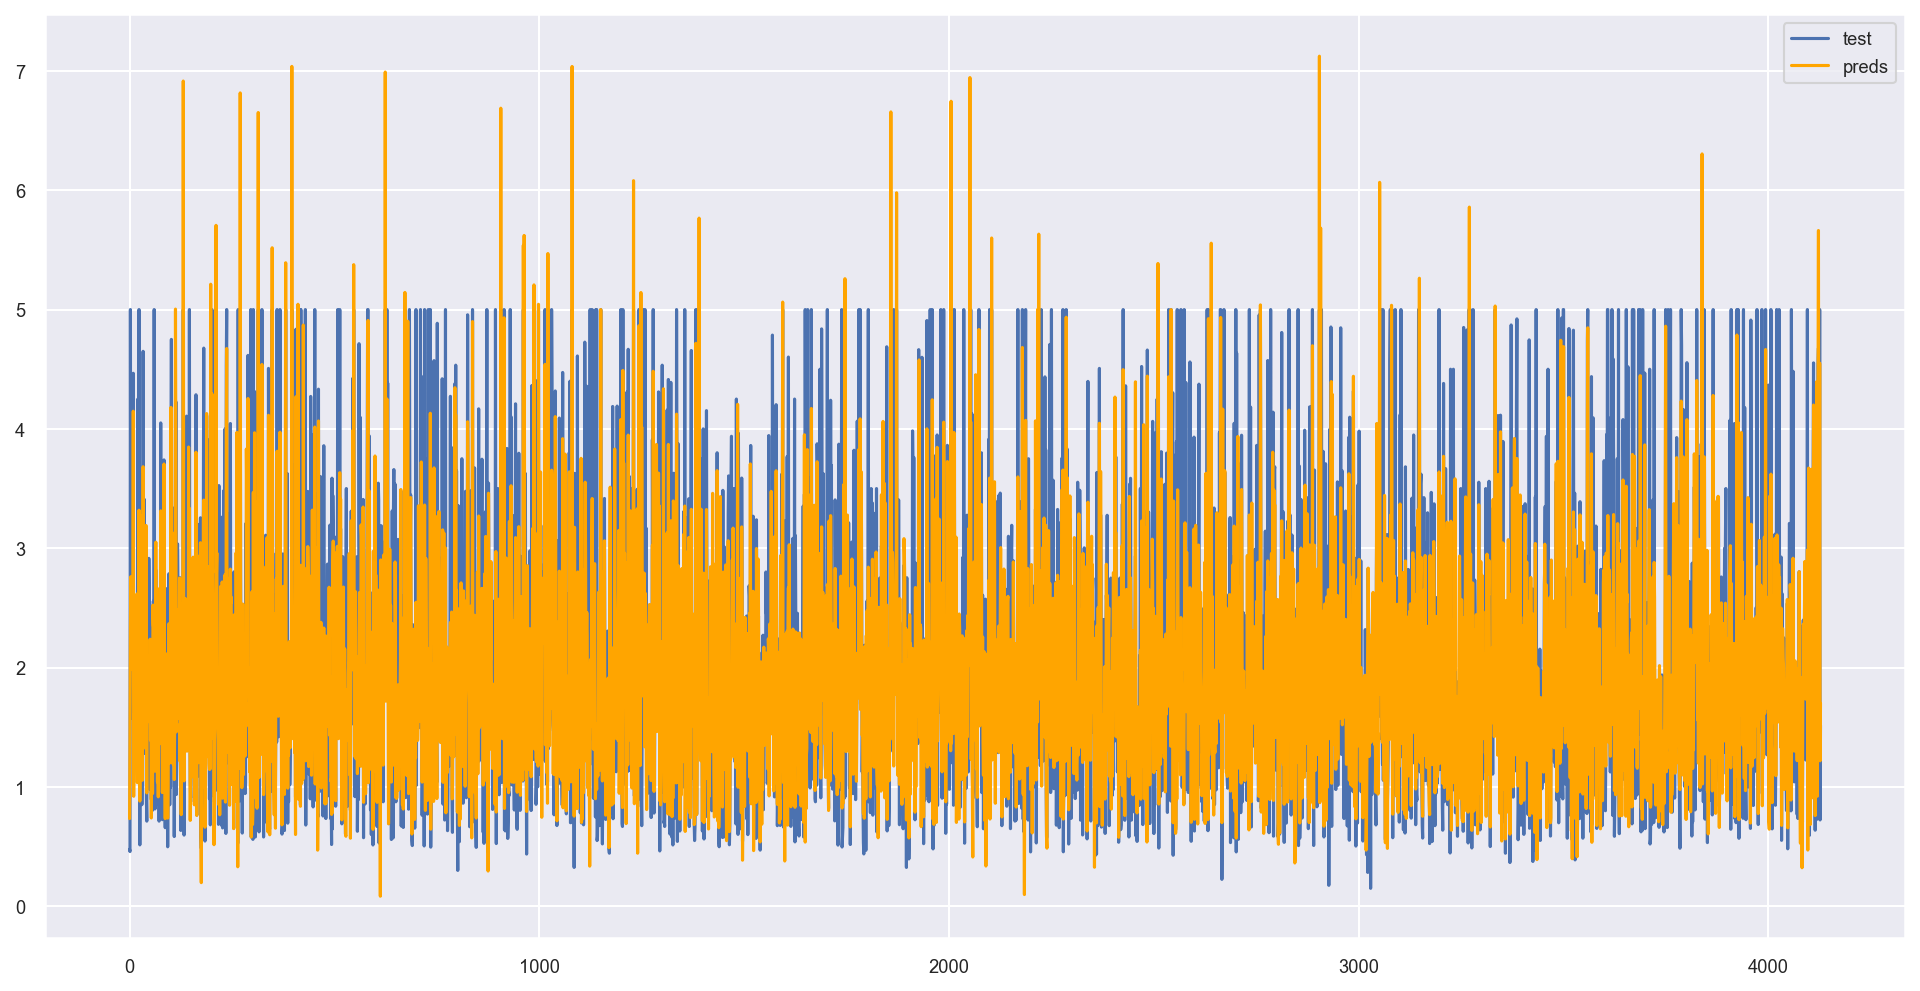

In [254]:
# визуализируем предсказания модели

plt.figure(figsize=(16, 8), dpi=150)

plt.plot(range(len(y_test)), y_test, label="test", c='b')
plt.plot(range(len(preds)), preds, label="preds", c='orange')

plt.legend();

In [255]:
stata = stata.append(
    {
        'Название модели': 'Базовое решение',
        'Кол-во скрытых слоев': 1,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'Metric Test': metric_test,
        'R2 test-pred': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,Metric Test,R2 test-pred
0,Базовое решение,1,100,relu,SGD,0.522832,0.565309


# 3. Изменение параметров ИНС

## 3.1 Изменяем число слоев

### 3.1.1 Модель с 2 скрытыми слоями нейронов

In [256]:
tf.random.set_seed(42)

model_1 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1),
]
)

model_1.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 50)                450       
                                                                 
 dense_136 (Dense)           (None, 50)                2550      
                                                                 
 dense_137 (Dense)           (None, 1)                 51        
                                                                 
Total params: 3,051
Trainable params: 3,051
Non-trainable params: 0
_________________________________________________________________


In [257]:
%%time

model_1.compile(optimizer=SGD(),
                   loss=mean_absolute_error,
                   metrics=['mae'])

history = model_1.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 10.9 s, sys: 1.17 s, total: 12.1 s
Wall time: 11.9 s


In [258]:
loss_test, metric_test = model_1.evaluate(X_test, y_test, verbose=verbose)
print(f'loss_test={loss_test:.5f}, metric_test={metric_test:.5f}')

preds = model_1.predict(X_test, verbose=0)
r2_test = r2_score(y_test, preds)
print(f'r2_test = {r2_test:.5f}')

loss_test=0.49783, metric_test=0.49783
r2_test = 0.58194


In [259]:
stata = stata.append(
    {
        'Название модели': 'Модель №1',
        'Кол-во скрытых слоев': 2,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'Metric Test': metric_test,
        'R2 test-pred': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,Metric Test,R2 test-pred
0,Базовое решение,1,100,relu,SGD,0.522832,0.565309
1,Модель №1,2,100,relu,SGD,0.497830,0.581938


### 3.1.2 Модель с 5 скрытыми слоями нейронов

In [260]:
tf.random.set_seed(42)

model_2 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(40, activation='relu'),
    Dense(35, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1),
]
)

model_2.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 40)                360       
                                                                 
 dense_139 (Dense)           (None, 35)                1435      
                                                                 
 dense_140 (Dense)           (None, 15)                540       
                                                                 
 dense_141 (Dense)           (None, 10)                160       
                                                                 
 dense_142 (Dense)           (None, 5)                 55        
                                                                 
 dense_143 (Dense)           (None, 1)                 6         
                                                                 
Total params: 2,556
Trainable params: 2,556
Non-train

In [261]:
%%time

model_2.compile(optimizer=SGD(),
                   loss=mean_absolute_error,
                   metrics=['mae'])

history = model_2.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 12.1 s, sys: 1.3 s, total: 13.4 s
Wall time: 12.7 s


In [262]:
loss_test, metric_test = model_2.evaluate(X_test, y_test, verbose=verbose)
print(f'loss_test={loss_test:.5f}, metric_test={metric_test:.5f}')

preds = model_2.predict(X_test, verbose=0)
r2_test = r2_score(y_test, preds)
print(f'r2_test = {r2_test:.5f}')

loss_test=0.54260, metric_test=0.54260
r2_test = 0.49078


In [263]:
stata = stata.append(
    {
        'Название модели': 'Модель №2',
        'Кол-во скрытых слоев': 5,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'Metric Test': metric_test,
        'R2 test-pred': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,Metric Test,R2 test-pred
0,Базовое решение,1,100,relu,SGD,0.522832,0.565309
1,Модель №1,2,100,relu,SGD,0.497830,0.581938
2,Модель №2,5,100,relu,SGD,0.542604,0.490776


### 3.1.3 Модель с 10 скрытыми слоями нейронов

In [264]:
tf.random.set_seed(42)

model_3 = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(20, activation='relu'),
    Dense(18, activation='relu'),
    Dense(16, activation='relu'),
    Dense(14, activation='relu'),
    Dense(10, activation='relu'),
    Dense(9, activation='relu'),
    Dense(8, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1),
]
)

model_3.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 20)                180       
                                                                 
 dense_145 (Dense)           (None, 18)                378       
                                                                 
 dense_146 (Dense)           (None, 16)                304       
                                                                 
 dense_147 (Dense)           (None, 14)                238       
                                                                 
 dense_148 (Dense)           (None, 10)                150       
                                                                 
 dense_149 (Dense)           (None, 9)                 99        
                                                                 
 dense_150 (Dense)           (None, 8)               

In [265]:
%%time

model_3.compile(optimizer=SGD(),
                   loss=mean_absolute_error,
                   metrics=['mae'])

history = model_3.fit(X_train, y_train,
               epochs=num_epochs,
               validation_data=(X_test, y_test),
               verbose=verbose
               )

CPU times: user 13.6 s, sys: 1.35 s, total: 15 s
Wall time: 21.3 s


In [266]:
loss_test, metric_test = model_3.evaluate(X_test, y_test, verbose=verbose)
print(f'loss_test={loss_test:.5f}, metric_test={metric_test:.5f}')

preds = model_3.predict(X_test, verbose=0)
r2_test = r2_score(y_test, preds)
print(f'r2_test = {r2_test:.5f}')

loss_test=0.52860, metric_test=0.52860
r2_test = 0.51276


In [267]:
stata = stata.append(
    {
        'Название модели': 'Модель №3',
        'Кол-во скрытых слоев': 10,
        'Кол-во нейронов скрытых слоев': 100,
        'Ф-я активации': 'relu',
        'Оптимизатор': 'SGD',
        'Metric Test': metric_test,
        'R2 test-pred': r2_test
    },
    ignore_index=True
)

stata

,Название модели,Кол-во скрытых слоев,Кол-во нейронов скрытых слоев,Ф-я активации,Оптимизатор,Metric Test,R2 test-pred
0,Базовое решение,1,100,relu,SGD,0.522832,0.565309
1,Модель №1,2,100,relu,SGD,0.497830,0.581938
2,Модель №2,5,100,relu,SGD,0.542604,0.490776
3,Модель №3,10,100,relu,SGD,0.528600,0.512762
